In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.datasets import mnist

In [4]:
import matplotlib.pyplot as plt

### Preprocessing

In [56]:
(x_train,y_train), (x_test,y_test)= mnist.load_data()

In [57]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

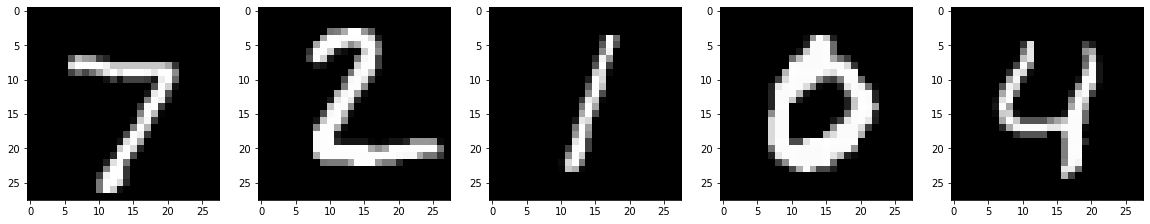

In [58]:
count=5
plt.figure(figsize=(20,10))

for i in range(count):
    ax = plt.subplot(2, count, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    
plt.show()
    

In [59]:
import numpy as np


In [60]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Modelling

In [61]:
actual_dim=28*28
bottleneck_dim=64
latent_dim=2

In [62]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda

In [63]:
from tensorflow.keras.losses import binary_crossentropy

#### Encoder 

In [64]:
inputs =Input(shape=(actual_dim,))
h = Dense(bottleneck_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

#### Choosing Parameters form Distribution

In [65]:
from tensorflow.keras import backend as K

#### Creating normal distribution

In [66]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon


In [67]:
z = Lambda(sampling)([z_mean, z_log_sigma])

#### Decoder

In [68]:
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

In [69]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
decoding_1 = Dense(bottleneck_dim, activation='relu')(latent_inputs)

outputs = Dense(actual_dim, activation='sigmoid')(decoding_1)

decoder = Model(latent_inputs, outputs, name='decoder')


#### VAE model

In [70]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

#### Loss Function

In [71]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *=  actual_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

#### Compiling

In [72]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [73]:
vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))


Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 186.3339 - val_loss: 167.6186
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 165.9554 - val_loss: 164.1730
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 163.3130 - val_loss: 162.1440
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 161.2313 - val_loss: 160.2811
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 159.5282 - val_loss: 158.8259
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 158.2088 - val_loss: 157.8480
Epoch 7/100
1875/1875 [==============================] - 4s 2ms/step - loss: 157.2337 - val_loss: 157.0209
Epoch 8/100
1875/1875 [==============================] - 4s 2ms/step - loss: 156.4150 - val_loss: 156.2258
Epoch 9/100
1875/1875 [==============================] - 4s 2ms/step - loss: 155.6877 - val_loss: 155.6011
Epoch 10/100
1875/1875 [=============

In [75]:
encoded = encoder.predict(x_test, batch_size=32)

In [81]:
encoded_n=np.array(encoded)

In [82]:
encoded_n.shape

(3, 10000, 2)

In [84]:
y_test.shape

(10000,)

In [86]:
encoded_n[:,:, 0]

array([[-0.34189308, -0.32917142,  2.3951664 , ..., -0.280847  ,
         0.24595512, -0.07501329],
       [-1.2034527 , -1.8409971 , -0.6989063 , ..., -1.6073157 ,
        -1.5191106 , -1.9958104 ],
       [-0.33652163, -0.3398606 ,  2.4067738 , ..., -0.29699695,
         0.21017273, -0.07904304]], dtype=float32)

#### Distribution

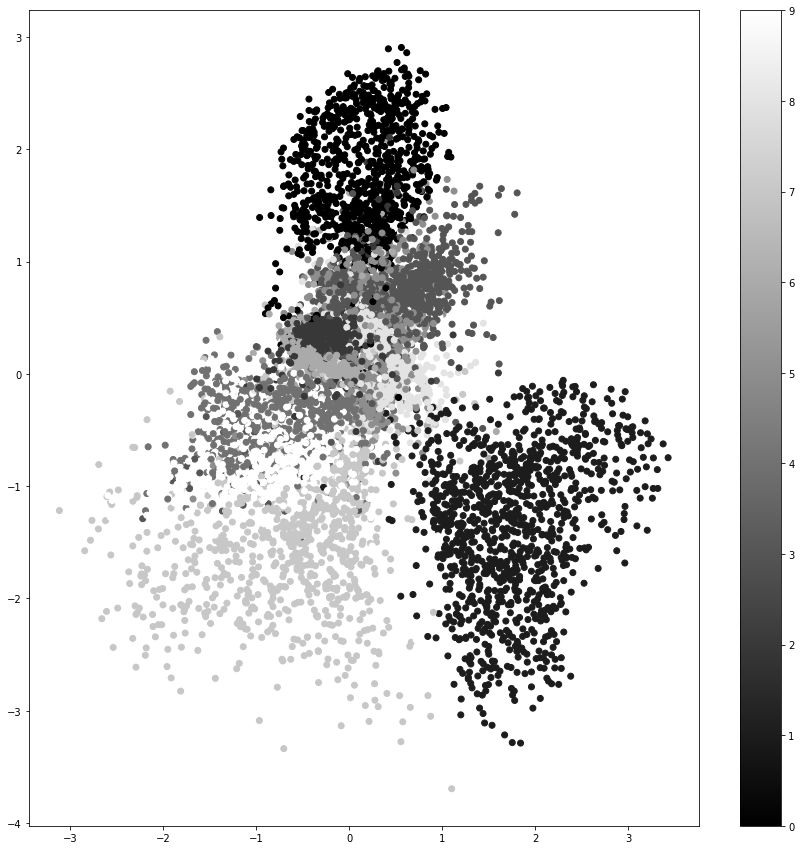

In [89]:
plt.figure(figsize=(15, 15))
plt.scatter(encoded_n[0,:, 0], encoded_n[0,:, 1], c=y_test)
plt.colorbar()
plt.show()

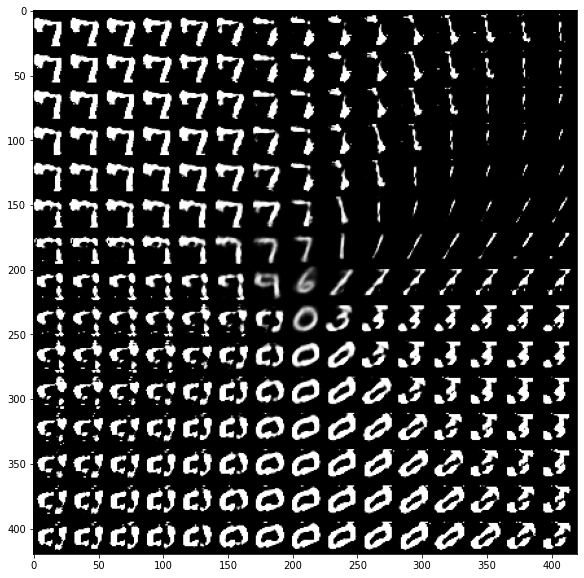

In [92]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    #print(yi)
    for j, xi in enumerate(grid_y):
        #print(xi)
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()